In [1]:
import numpy as np
from tqdm.auto import tqdm
from ctapipe.instrument import CameraGeometry
from ctapipe.image.toymodel import Gaussian
from ctapipe.image import hillas_parameters
from ctapipe.visualization import CameraDisplay
from ctapipe.image.cleaning import tailcuts_clean
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.stats import norm

# Container classe from core

In [2]:
import logging
import warnings
from collections import defaultdict
from functools import partial
from inspect import isclass
from pprint import pformat
from textwrap import dedent, wrap

import numpy as np
from astropy.units import Quantity, Unit, UnitConversionError

log = logging.getLogger(__name__)

__all__ = ["Container", "Field", "FieldValidationError", "Map"]


def _fqdn(obj):
    return f"{obj.__module__}.{obj.__qualname__}"


class FieldValidationError(ValueError):
    pass


class Field:
    """
    Class for storing data in a `Container`.

    Parameters
    ----------
    default :
        Default value of the item. This will be set when the `Container`
        is constructed, as well as when  ``Container.reset`` is called.
        This should only be used for immutable values. For mutable values,
        use ``default_factory`` instead.
    description : str
        Help text associated with the item
    unit : str or astropy.units.core.UnitBase
        unit to convert to when writing output, or None for no conversion
    ucd : str
        universal content descriptor (see Virtual Observatory standards)
    type : type
        expected type of value
    dtype : str or np.dtype
        expected data type of the value, None to ignore in validation.
        Means value is expected to be a numpy array or astropy quantity
    ndim : int or None
        expected dimensionality of the data, for arrays, None to ignore
    allow_none : bool
        if the value of None is given to this Field, skip validation
    max_len : int
        if type is str, max_len is the maximum number of bytes of the utf-8
        encoded string to be used.
    default_factory : Callable
        A callable providing a fresh instance as default value.
    """

    def __init__(
        self,
        default=None,
        description="",
        unit=None,
        ucd=None,
        dtype=None,
        type=None,
        ndim=None,
        allow_none=True,
        max_length=None,
        default_factory=None,
    ):
        self.default = default
        self.default_factory = default_factory
        self.description = description
        self.unit = Unit(unit) if unit is not None else None
        self.ucd = ucd
        self.dtype = np.dtype(dtype) if dtype is not None else None
        self.type = type
        self.ndim = ndim
        self.allow_none = allow_none
        self.max_length = max_length

        if default_factory is not None and default is not None:
            raise ValueError("Must only provide one of default or default_factory")

    def __repr__(self):
        if self.default_factory is not None:
            if isclass(self.default_factory):
                default = _fqdn(self.default_factory)
            elif isinstance(self.default_factory, partial):
                # case for `partial(Map, Container)`
                cls = _fqdn(self.default_factory.args[0])
                if self.default_factory.func is Map:
                    func = "Map"
                else:
                    func = repr(self.default_factory.func)
                default = f"{func}({cls})"
            else:
                # make sure numpy arrays are not dominating everything
                with np.printoptions(threshold=4, precision=3, edgeitems=2):
                    default = str(self.default_factory())
        else:
            default = str(self.default)
        cmps = [f"Field(default={default}"]
        if self.unit is not None:
            cmps.append(f", unit={self.unit}")
        if self.dtype is not None:
            cmps.append(f", dtype={self.dtype}")
        if self.ndim is not None:
            cmps.append(f", ndim={self.ndim}")
        if self.type is not None:
            cmps.append(f", type={self.type.__name__}")
        if self.allow_none is False:
            cmps.append(", allow_none=False")
        if self.max_length is not None:
            cmps.append(f", max_length={self.max_length}")
        cmps.append(")")
        return "".join(cmps)

    def __str__(self):
        desc = f"{self.description} with default {self.default}"
        if self.unit is not None:
            desc += f" [{self.unit}]"
        if self.ndim is not None:
            desc += f" as a {self.ndim}-D array"
        if self.dtype is not None:
            desc += f" with dtype {self.dtype}"
        if self.type is not None:
            desc += f" with type {self.type}"

        return desc

    def validate(self, value):
        """
        check that a given value is appropriate for this Field

        Parameters
        ----------
        value: Any
           the value to test

        Raises
        ------
        FieldValidationError:
            if the value is not valid
        """

        if self.allow_none and value is None:
            return

        errorstr = f"the value '{value}' ({type(value)}) is invalid: "

        if self.type is not None and not isinstance(value, self.type):
            raise FieldValidationError(
                f"{errorstr} Should be an instance of {self.type}"
            )

        if isinstance(value, Container):
            # recursively check sub-containers
            value.validate()
            return

        if isinstance(value, Map):
            for key, map_value in value.items():
                if isinstance(map_value, Container):
                    try:
                        map_value.validate()
                    except FieldValidationError as err:
                        raise FieldValidationError(f"[{key}]: {err} ")
            return

        if self.unit is not None:
            if not isinstance(value, Quantity):
                raise FieldValidationError(
                    f"{errorstr} Should have units of {self.unit}"
                ) from None
            try:
                value.to(self.unit)
            except UnitConversionError as err:
                raise FieldValidationError(f"{errorstr}: {err}")

            # strip off the units now, so we can test the rest without units
            value = value.value

        if self.ndim is not None:
            # should be a numpy array
            if not isinstance(value, np.ndarray):
                raise FieldValidationError(f"{errorstr} Should be an ndarray")
            if value.ndim != self.ndim:
                raise FieldValidationError(
                    f"{errorstr} Should have dimensionality {self.ndim}"
                )
            if value.dtype != self.dtype:
                raise FieldValidationError(
                    f"{errorstr} Has dtype "
                    f"{value.dtype}, should have dtype"
                    f" {self.dtype}"
                )
        else:
            # not a numpy array
            if self.dtype is not None:
                if not isinstance(value, self.dtype.type):
                    raise FieldValidationError(
                        f"{errorstr} Should have numpy dtype {self.dtype}"
                    )


class DeprecatedField(Field):
    """used to mark which fields may be removed in next version"""

    def __init__(self, default, description="", unit=None, ucd=None, reason=""):
        super().__init__(default=default, description=description, unit=unit, ucd=ucd)
        warnings.warn(f"Field {self} is deprecated. {reason}", DeprecationWarning)
        self.reason = reason


_doc_template = """{doc}

Attributes
----------
{fields}
meta : dict
    dict of attached metadata
prefix : str
    Prefix attached to column names when saved to a table or file
"""


def _build_docstring(doc, fields):
    fields = [f"{k} : {f!r}\n    {f.description}" for k, f in fields.items()]
    return _doc_template.format(doc=dedent(doc), fields="\n".join(fields))


class ContainerMeta(type):
    """
    The MetaClass for `Container`

    It reserves __slots__ for every class variable,
    that is of instance `Field` and sets all other class variables
    as read-only for the instances.

    This makes sure, that the metadata is immutable,
    and no new fields can be added to a container by accident.
    """

    def __new__(cls, name, bases, dct):
        field_names = [k for k, v in dct.items() if isinstance(v, Field)]
        dct["__slots__"] = tuple(field_names + ["meta", "prefix"])
        dct["fields"] = {}

        # inherit fields from baseclasses
        for b in bases:
            if issubclass(b, Container):
                for k, v in b.fields.items():
                    dct["fields"][k] = v

        for k in field_names:
            dct["fields"][k] = dct.pop(k)

        for field_name, field in dct["fields"].items():
            field.name = field_name

        dct["__doc__"] = _build_docstring(dct.get("__doc__", ""), dct["fields"])

        new_cls = type.__new__(cls, name, bases, dct)

        # if prefix was not set as a class variable, build a default one
        if "default_prefix" not in dct:
            new_cls.default_prefix = name.lower().replace("container", "")

        return new_cls


class Container(metaclass=ContainerMeta):
    """Generic class that can hold and accumulate data to be passed
    between Components.

    The purpose of this class is to provide a flexible data structure
    that works a bit like a dict or blank Python class, but prevents
    the user from accessing members that have not been defined a
    priori (more like a C struct), and also keeps metadata information
    such as a description, defaults, and units for each item in the
    container.

    Containers can transform the data into a `dict` using the
    ``as_dict`` method.  This allows them to be written to an
    output table for example, where each Field defines a column. The
    `dict` conversion can be made recursively and even flattened so
    that a nested set of `Containers <Container>`_ can be translated into a set of
    columns in a flat table without naming conflicts (the name of the
    parent Field is prepended).

    Only members of instance `Field` will be used as output.
    For hierarchical data structures, Field can use `Container`
    subclasses or a `Map` as the default value.

    >>> import astropy.units as u
    >>> class MyContainer(Container):
    ...     x = Field(100, "The X value")
    ...     energy = Field(-1, "Energy measurement", unit=u.TeV)
    ...
    >>> cont = MyContainer()
    >>> print(cont.x)
    100
    >>> # metadata will become header keywords in an output file:
    >>> cont.meta["KEY"] = "value"

    `Fields <Field>`_ inside `Containers <Container>`_ can contain instances of other
    containers, to allow for a hierarchy of containers, and can also
    contain a `Map` for the case where one wants e.g. a set of
    sub-classes indexed by a value like the ``telescope_id``. Examples
    of this can be found in `ctapipe.containers`

    `Container` works by shadowing all class variables (which must be
    instances of `Field`) with instance variables of the same name that
    hold the actual data. If ``reset`` is called, all
    instance variables are reset to their default values as defined in
    the class.

    Finally, a Container can have associated metadata via its
    `meta` attribute, which is a `dict` of keywords to values.

    """

    def __init__(self, prefix=None, **fields):
        self.meta = {}
        # __slots__ cannot be provided with defaults
        # via class variables, so we use a `default_prefix` class variable
        # and an instance variable `prefix` in `__slots__`
        self.prefix = prefix if prefix is not None else self.default_prefix

        for k in set(self.fields).difference(fields):
            # deepcopy of None is surprisingly slow
            field = self.fields[k]
            if field.default_factory is not None:
                default = field.default_factory()
            else:
                default = field.default
            setattr(self, k, default)

        for k, v in fields.items():
            setattr(self, k, v)

    def __getitem__(self, key):
        return getattr(self, key)

    def __setitem__(self, key, value):
        return setattr(self, key, value)

    def items(self, add_prefix=False):
        """Generator over (key, value) pairs for the items"""
        if not add_prefix or self.prefix == "":
            return ((k, getattr(self, k)) for k in self.fields.keys())

        return ((self.prefix + "_" + k, getattr(self, k)) for k in self.fields.keys())

    def keys(self):
        """Get the keys of the container"""
        return self.fields.keys()

    def values(self):
        """Get the keys of the container"""
        return (getattr(self, k) for k in self.fields.keys())

    def as_dict(self, recursive=False, flatten=False, add_prefix=False, add_key=False):
        """
        Convert the `Container` into a dictionary

        Parameters
        ----------
        recursive: bool
            sub-Containers should also be converted to dicts
        flatten: type
            return a flat dictionary, with any sub-field keys generated
            by appending the sub-Container name.
        add_prefix: bool
            include the container's prefix in the name of each item
        add_key: bool
            include map key
        """
        if not recursive:
            return dict(self.items(add_prefix=add_prefix))

        kwargs = dict(
            recursive=recursive,
            add_prefix=add_prefix,
            flatten=flatten,
            add_key=add_key,
        )

        d = dict()
        for key, val in self.items(add_prefix=add_prefix):
            if isinstance(val, Container | Map):
                if flatten:
                    d.update(val.as_dict(**kwargs))
                else:
                    d[key] = val.as_dict(**kwargs)
            else:
                d[key] = val
        return d

    def reset(self):
        """
        Reset all values back to their default values

        Parameters
        ----------
        recursive: bool
            If true, also reset all sub-containers
        """

        for name, field in self.fields.items():
            if field.default_factory is not None:
                setattr(self, name, field.default_factory())
            else:
                setattr(self, name, field.default)

    def update(self, **values):
        """
        update more than one parameter at once (e.g. ``update(x=3,y=4)``
        or ``update(**dict_of_values)``)
        """
        for key in values:
            self[key] = values[key]

    def __str__(self):
        return pformat(self.as_dict(recursive=True))

    def __repr__(self):
        text = ["{}.{}:".format(type(self).__module__, type(self).__name__)]
        for name, item in self.fields.items():
            extra = ""
            if isinstance(getattr(self, name), Container):
                extra = ".*"
            if isinstance(getattr(self, name), Map):
                extra = "[*]"
            desc = "{:>30s}: {}".format(name + extra, str(item))
            lines = wrap(desc, 80, subsequent_indent=" " * 32)
            text.extend(lines)
        return "\n".join(text)

    def validate(self):
        """
        Check that all fields in the Container have the expected characteristics (as
        defined by the Field metadata).  This is not intended to be run every time a
        Container is filled, since it is slow, only for testing a first event.

        Raises
        ------
        ValueError:
            if the Container's values are not valid
        """
        for name, field in self.fields.items():
            try:
                field.validate(self[name])
            except FieldValidationError as err:
                raise FieldValidationError(
                    f"{self.__class__.__name__} Field '{name}': {err}"
                )


class Map(defaultdict):
    """A dictionary of sub-containers that can be added to a Container. This
    may be used e.g. to store a set of identical sub-Containers (e.g. indexed
    by ``tel_id`` or algorithm name).
    """

    def as_dict(self, recursive=False, flatten=False, add_prefix=False, add_key=False):
        if not recursive:
            return dict(self.items())
        else:
            d = dict()
            for key, val in self.items():
                if isinstance(val, Container) or isinstance(val, Map):
                    if flatten:
                        d.update(
                            {
                                f"{key}_{k}" if add_key else k: v
                                for k, v in val.as_dict(
                                    recursive, add_prefix=add_prefix
                                ).items()
                            }
                        )
                    else:
                        d[key] = val.as_dict(
                            recursive=recursive, flatten=flatten, add_prefix=add_prefix
                        )
                    continue
                d[key] = val
            return d

    def reset(self, recursive=True):
        """Calls all ``Container.reset`` for all values in the Map"""
        for val in self.values():
            if isinstance(val, Container):
                val.reset(recursive=recursive)

    def __repr__(self):
        if isclass(self.default_factory):
            default = _fqdn(self.default_factory)
        else:
            default = repr(self.default_factory)
        return f"{self.__class__.__name__}({default}, {dict.__repr__(self)!s})"

# Container class

In [3]:
"""
Container structures for data that should be read or written to disk
"""

import enum
from functools import partial

import numpy as np
from astropy import units as u
from astropy.time import Time
from numpy import nan

#from .core import Container, Field, Map

__all__ = [
    "HillasParametersContainer",
    "CoreParametersContainer",
    "ImageParametersContainer",
]




class BaseHillasParametersContainer(Container):
    """
    Base container for hillas parameters to
    allow the CameraHillasParametersContainer to
    be assigned to an ImageParametersContainer as well.
    """

    intensity = Field(nan, "total intensity (size)")
    skewness = Field(nan, "measure of the asymmetry")
    kurtosis = Field(nan, "measure of the tailedness")


class CameraHillasParametersContainer(BaseHillasParametersContainer):
    """
    Hillas Parameters in the camera frame. The cog position
    is given in meter from the camera center.
    """

    default_prefix = "camera_frame_hillas"
    x = Field(nan * u.m, "centroid x coordinate", unit=u.m)
    y = Field(nan * u.m, "centroid x coordinate", unit=u.m)
    r = Field(nan * u.m, "radial coordinate of centroid", unit=u.m)
    phi = Field(nan * u.deg, "polar coordinate of centroid", unit=u.deg)

    length = Field(nan * u.m, "standard deviation along the major-axis", unit=u.m)
    length_uncertainty = Field(nan * u.m, "uncertainty of length", unit=u.m)
    width = Field(nan * u.m, "standard spread along the minor-axis", unit=u.m)
    width_uncertainty = Field(nan * u.m, "uncertainty of width", unit=u.m)
    psi = Field(nan * u.deg, "rotation angle of ellipse", unit=u.deg)
    psi_uncertainty = Field(nan * u.deg, "uncertainty of psi", unit=u.deg)
    deltha = Field(nan * u.deg, "rotation angle of ellipse", unit=u.deg)
    deltha_uncertainty = Field(nan * u.deg, "uncertainty of deltha", unit=u.deg)
  


class HillasParametersContainer(BaseHillasParametersContainer):
    """
    Hillas Parameters in a spherical system centered on the pointing position
    (TelescopeFrame). The cog position is given as offset in
    longitude and latitude in degree.
    """

    default_prefix = "hillas"
    fov_lon = Field(
        nan * u.deg,
        "longitude angle in a spherical system centered on the pointing position",
        unit=u.deg,
    )
    fov_lat = Field(
        nan * u.deg,
        "latitude angle in a spherical system centered on the pointing position",
        unit=u.deg,
    )
    r = Field(nan * u.deg, "radial coordinate of centroid", unit=u.deg)
    phi = Field(nan * u.deg, "polar coordinate of centroid", unit=u.deg)

    length = Field(nan * u.deg, "standard deviation along the major-axis", unit=u.deg)
    length_uncertainty = Field(nan * u.deg, "uncertainty of length", unit=u.deg)
    width = Field(nan * u.deg, "standard spread along the minor-axis", unit=u.deg)
    width_uncertainty = Field(nan * u.deg, "uncertainty of width", unit=u.deg)
    psi = Field(nan * u.deg, "rotation angle of ellipse", unit=u.deg)
    psi_uncertainty = Field(nan * u.deg, "uncertainty of psi", unit=u.deg)
    deltha = Field(nan * u.deg, "rotation angle of ellipse", unit=u.deg)
    deltha_uncertainty = Field(nan * u.deg, "uncertainty of deltha", unit=u.deg)




# Hillas classes

In [4]:
# Licensed under a 3-clause BSD style license - see LICENSE.rst
# -*- coding: UTF-8 -*-
"""
Hillas-style moment-based shower image parametrization.
"""

import astropy.units as u
import numpy as np
from astropy.coordinates import Angle

#from ..containers import CameraHillasParametersContainer, HillasParametersContainer

HILLAS_ATOL = np.finfo(np.float64).eps


__all__ = ["hillas_parameters", "HillasParameterizationError"]


def camera_to_shower_coordinates(x, y, cog_x, cog_y, psi):
    """
    Return longitudinal and transverse coordinates for x and y
    for a given set of hillas parameters

    Parameters
    ----------
    x: u.Quantity[length]
        x coordinate in camera coordinates
    y: u.Quantity[length]
        y coordinate in camera coordinates
    cog_x: u.Quantity[length]
        x coordinate of center of gravity
    cog_y: u.Quantity[length]
        y coordinate of center of gravity
    psi: Angle
        orientation angle

    Returns
    -------
    longitudinal: astropy.units.Quantity
        longitudinal coordinates (along the shower axis)
    transverse: astropy.units.Quantity
        transverse coordinates (perpendicular to the shower axis)
    """
    cos_psi = np.cos(psi)
    sin_psi = np.sin(psi)

    delta_x = x - cog_x
    delta_y = y - cog_y

    longi = delta_x * cos_psi + delta_y * sin_psi
    trans = delta_x * -sin_psi + delta_y * cos_psi

    return longi, trans


class HillasParameterizationError(RuntimeError):
    pass


def hillas_parameters(geom, image):
    """
    Compute Hillas parameters for a given shower image.

    Implementation uses a PCA analogous to the implementation in
    src/main/java/fact/features/HillasParameters.java
    from
    https://github.com/fact-project/fact-tools

    The recommended form is to pass only the sliced geometry and image
    for the pixels to be considered.

    Each method gives the same result, but vary in efficiency

    Parameters
    ----------
    geom: ctapipe.instrument.CameraGeometry
        Camera geometry, the cleaning mask should be applied to improve performance
    image : array_like
        Charge in each pixel, the cleaning mask should already be applied to
        improve performance.

    Returns
    -------
    HillasParametersContainer:
        container of hillas parametesr
    """
    unit = geom.pix_x.unit
    pix_x = geom.pix_x.to_value(unit)
    pix_y = geom.pix_y.to_value(unit)
    pix_area = geom.pix_area.to_value(unit**2)
    image = np.asanyarray(image, dtype=np.float64)

    if isinstance(image, np.ma.masked_array):
        image = np.ma.filled(image, 0)

    if not (pix_x.shape == pix_y.shape == image.shape):
        raise ValueError("Image and pixel shape do not match")

    size = np.sum(image)

    if size == 0.0:
        raise HillasParameterizationError("size=0, cannot calculate HillasParameters")

    # calculate the cog as the mean of the coordinates weighted with the image
    cog_x = np.average(pix_x, weights=image)
    cog_y = np.average(pix_y, weights=image)

    # polar coordinates of the cog
    cog_r = np.linalg.norm([cog_x, cog_y])
    cog_phi = np.arctan2(cog_y, cog_x)

    # do the PCA for the hillas parameters
    delta_x = pix_x - cog_x
    delta_y = pix_y - cog_y

    # The ddof=0 makes this comparable to the other methods,
    # but ddof=1 should be more correct, mostly affects small showers
    # on a percent level
    cov = np.cov(delta_x, delta_y, aweights=image, ddof=0)
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # round eig_vals to get rid of nans when eig val is something like -8.47032947e-22
    near_zero = np.isclose(eig_vals, 0, atol=HILLAS_ATOL)
    eig_vals[near_zero] = 0

    # width and length are eigen values of the PCA
    width, length = np.sqrt(eig_vals)

    # psi is the angle of the eigenvector to length to the x-axis
    vx, vy = eig_vecs[0, 1], eig_vecs[1, 1]

    # *** INICIO DE NUEVO CÓDIGO PARA EL CÁLCULO DE DELTHA ***
    
    # Cálculo de deltha
    dd = cov[1, 1] - cov[0, 0]  # Diferencia de varianzas
    vxy = cov[0, 1]  # Covarianza
    Q = np.hypot(dd, 2.0 * vxy)  # Factor Q
    
  
     
   # Verificación de valores antes de calcular deltha
    #print(f"dd: {dd}, vxy: {vxy}, Q: {Q}")
    if Q == 0 or vxy == 0:
        deltha = np.nan
        #print(f"Invalid deltha calculation: Q={Q}, vxy={vxy}")
    else:
        deltha = np.arctan2(dd + Q, 2.0 * vxy)
        #print(f"Valid deltha calculated: {deltha}") 

    
    #deltha = np.arctan2(dd + Q, 2.0 * vxy)  # Cálculo de deltha

    # Cálculo de la incertidumbre de deltha
    A = ((delta_x**2.0) - cov[0][0]) / size
    B = ((delta_y**2.0) - cov[1][1]) / size
    C = ((delta_x * delta_y) - cov[0][1]) / size
    #deltha_error2 = np.sum((((A * dd) + (B * vxy) + (C * Q)) ** 2.0) * image)
    #deltha_error = np.sqrt(deltha_error2)  # Incertidumbre de deltha
    
    
    # Verificación de valores antes de calcular deltha
    #print(f"Calculating deltha: dd={dd}, Q={Q}, vxy={vxy}")
    
    if np.abs(Q) > 1e-10 and np.abs(vxy) > 1e-10:  # Evita divisiones por cero
        deltha = np.arctan2(dd + Q, 2.0 * vxy)
    else:
        deltha = np.nan  # o un valor por defecto que tenga sentido

    #print(f"Calculated deltha dentro de Hillas: {deltha} deg")
    
    # Verificar si todos los elementos de A, B y C son finitos
    if np.all(np.isfinite(A)) and np.all(np.isfinite(B)) and np.all(np.isfinite(C)):
        deltha_error2 = np.sum((((A * dd) + (B * vxy) + (C * Q)) ** 2.0) * image)
        deltha_error = np.sqrt(deltha_error2)
    else:
        deltha_error = np.nan
        #print(f"Invalid deltha_error calculation: A={A}, B={B}, C={C}, dd={dd}, vxy={vxy}, Q={Q}")


    # *** FIN DE NUEVO CÓDIGO PARA EL CÁLCULO DE DELTHA ***

    
    # avoid divide by 0 warnings
    # psi will be consistently defined in the range (-pi/2, pi/2)
    if length == 0:
        psi = psi_uncert = skewness_long = kurtosis_long = np.nan
    else:
        if vx != 0:
            psi = np.arctan(vy / vx)
        else:
            psi = np.pi / 2

        # calculate higher order moments along shower axes
        cos_psi = np.cos(psi)
        sin_psi = np.sin(psi)
        longi = delta_x * cos_psi + delta_y * sin_psi
        trans = delta_x * -sin_psi + delta_y * cos_psi

        m3_long = np.average(longi**3, weights=image)
        skewness_long = m3_long / length**3

        m4_long = np.average(longi**4, weights=image)
        kurtosis_long = m4_long / length**4

        # lsq solution to determine uncertainty on phi
        W = np.diag(image / pix_area)
        X = np.column_stack([longi, np.ones_like(longi)])
        cov = np.linalg.inv(X.T @ W @ X)
        p = cov @ X.T @ W @ trans
        psi_uncert = np.sqrt(cov[0, 0] / np.cos(p[0]) ** 2)

    # Compute of the Hillas parameters uncertainties.
    # Implementation described in [hillas_uncertainties]_ This is an internal MAGIC document
    # not generally accessible.

    # intermediate variables
    cos_2psi = np.cos(2 * psi)
    a = (1 + cos_2psi) / 2
    b = (1 - cos_2psi) / 2
    c = np.sin(2 * psi)

    A = ((delta_x**2.0) - cov[0][0]) / size
    B = ((delta_y**2.0) - cov[1][1]) / size
    C = ((delta_x * delta_y) - cov[0][1]) / size

    # Hillas's uncertainties

    # avoid divide by 0 warnings
    if length == 0:
        length_uncertainty = np.nan
    else:
        length_uncertainty = np.sqrt(
            np.sum((((a * A) + (b * B) + (c * C)) ** 2.0) * image)
        ) / (2 * length)

    if width == 0:
        width_uncertainty = np.nan
    else:
        width_uncertainty = np.sqrt(
            np.sum((((b * A) + (a * B) + (-c * C)) ** 2.0) * image)
        ) / (2 * width)

    if unit.is_equivalent(u.m):
        return CameraHillasParametersContainer(
            x=u.Quantity(cog_x, unit),
            y=u.Quantity(cog_y, unit),
            r=u.Quantity(cog_r, unit),
            phi=Angle(cog_phi, unit=u.rad),
            intensity=size,
            length=u.Quantity(length, unit),
            length_uncertainty=u.Quantity(length_uncertainty, unit),
            width=u.Quantity(width, unit),
            width_uncertainty=u.Quantity(width_uncertainty, unit),
            psi=Angle(psi, unit=u.rad),
            psi_uncertainty=Angle(psi_uncert, unit=u.rad),
            skewness=skewness_long,
            kurtosis=kurtosis_long,
            # *** NUEVO: Agregar deltha y su incertidumbre en grados ***
            deltha=Angle(deltha, unit=u.rad),  # deltha en grados
            deltha_uncertainty=Angle(deltha_error, unit=u.rad),  # Incertidumbre de deltha en grados
        )
    return HillasParametersContainer(
        fov_lon=u.Quantity(cog_x, unit),
        fov_lat=u.Quantity(cog_y, unit),
        r=u.Quantity(cog_r, unit),
        phi=Angle(cog_phi, unit=u.rad),
        intensity=size,
        length=u.Quantity(length, unit),
        length_uncertainty=u.Quantity(length_uncertainty, unit),
        width=u.Quantity(width, unit),
        width_uncertainty=u.Quantity(width_uncertainty, unit),
        psi=Angle(psi, unit=u.rad),
        psi_uncertainty=Angle(psi_uncert, unit=u.rad),
        skewness=skewness_long,
        kurtosis=kurtosis_long,
        # *** NUEVO: Agregar deltha y su incertidumbre en grados ***
        deltha=Angle(deltha, unit=u.rad),  # deltha en grados
        deltha_uncertainty=Angle(deltha_error, unit=u.rad),  # Incertidumbre de deltha en grados
    )

# Toymodel

In [5]:
# Licensed under a 3-clause BSD style license - see LICENSE.rst
"""
Utilities to generate toymodel (fake) reconstruction inputs for testing
purposes.

Examples:

.. code-block:: python

    >>> from ctapipe.instrument import CameraGeometry
    >>> geom = CameraGeometry.make_rectangular(20, 20)
    >>> showermodel = Gaussian(
    ...    x=0.25 * u.m, y=0.0 * u.m,
    ...    length=0.1 * u.m, width=0.02 * u.m,
    ...    psi='40d'
    ... )
    >>> image, signal, noise = showermodel.generate_image(geom, intensity=1000)
    >>> print(image.shape)
    (400,)
"""

from abc import ABCMeta, abstractmethod

import astropy.units as u
import numpy as np
from numpy.random import default_rng
from scipy.ndimage import convolve1d
from scipy.stats import multivariate_normal, norm, skewnorm

from ctapipe.calib.camera.gainselection import GainChannel
from ctapipe.image.hillas import camera_to_shower_coordinates
from ctapipe.utils import linalg

__all__ = [
    "WaveformModel",
    "Gaussian",
    "SkewedGaussian",
    "ImageModel",
    "obtain_time_image",
]


TOYMODEL_RNG = default_rng(0)
VALID_GAIN_CHANNEL = {"HIGH", "LOW", "ALL"}


def obtain_time_image(x, y, centroid_x, centroid_y, psi, time_gradient, time_intercept):
    """Create a pulse time image for a toymodel shower. Assumes the time development
    occurs only along the longitudinal (major) axis of the shower, and scales
    linearly with distance along the axis.

    Parameters
    ----------
    x : u.Quantity[length]
        X camera coordinate to evaluate the time at.
        Usually the array of pixel X positions
    y : u.Quantity[length]
        Y camera coordinate to evaluate the time at.
        Usually the array of pixel Y positions
    centroid_x : u.Quantity[length]
        X camera coordinate for the centroid of the shower
    centroid_y : u.Quantity[length]
        Y camera coordinate for the centroid of the shower
    psi : convertible to `astropy.coordinates.Angle`
        rotation angle about the centroid (0=x-axis)
    time_gradient : u.Quantity[time/angle]
        Rate at which the time changes with distance along the shower axis
    time_intercept : u.Quantity[time]
        Pulse time at the shower centroid

    Returns
    -------
    float or ndarray
        Pulse time in nanoseconds at (x, y)

    """
    unit = x.unit
    x = x.to_value(unit)
    y = y.to_value(unit)
    centroid_x = centroid_x.to_value(unit)
    centroid_y = centroid_y.to_value(unit)
    psi = psi.to_value(u.rad)
    time_gradient = time_gradient.to_value(u.ns / unit)
    time_intercept = time_intercept.to_value(u.ns)

    longitudinal, _ = camera_to_shower_coordinates(x, y, centroid_x, centroid_y, psi)
    return longitudinal * time_gradient + time_intercept


class WaveformModel:
    @u.quantity_input(reference_pulse_sample_width=u.ns, sample_width=u.ns)
    def __init__(self, reference_pulse, reference_pulse_sample_width, sample_width):
        """Generate a toy model waveform for each gain channel using the reference
        pulse shape of a camera. Useful for testing image extraction algorithms.

        Does not include the electronic noise and the Excess Noise Factor of
        the photosensor, and therefore should not be used to make charge
        resolution conclusions about a camera.

        Parameters
        ----------
        reference_pulse_sample_width : u.Quantity[time]
            Sample width of the reference pulse shape
        reference_pulse : ndarray
            Reference pulse shape for each channel
        sample_width : u.Quantity[time]
            Sample width of the waveform

        """
        self.n_channels = reference_pulse.shape[-2]
        self.upsampling = 10
        reference_pulse_sample_width = reference_pulse_sample_width.to_value(u.ns)
        sample_width_ns = sample_width.to_value(u.ns)
        ref_max_sample = reference_pulse[0].size * reference_pulse_sample_width
        reference_pulse_x = np.arange(0, ref_max_sample, reference_pulse_sample_width)
        self.ref_width_ns = sample_width_ns / self.upsampling
        self.ref_interp_x = np.arange(0, reference_pulse_x.max(), self.ref_width_ns)
        self.ref_interp_y = np.zeros((self.n_channels, self.ref_interp_x.size))
        for channel in range(self.n_channels):
            self.ref_interp_y[channel] = np.interp(
                self.ref_interp_x, reference_pulse_x, reference_pulse[channel]
            )
        self.ref_interp_y = (
            self.ref_interp_y.T / (self.ref_interp_y.sum(-1) * self.ref_width_ns)
        ).T
        self.origin = self.ref_interp_y.argmax(-1) - self.ref_interp_y[0].size // 2

    def get_waveform(self, charge, time, n_samples):
        """Obtain the waveform toy model.

        Parameters
        ----------
        charge : ndarray
            Amount of charge in each pixel
            Shape: (n_pixels)
        time : ndarray
            The signal time in the waveform in nanoseconds
            Shape: (n_pixels)
        n_samples : int
            Number of samples in the waveform

        Returns
        -------
        waveform : ndarray
            Toy model waveform
            Shape (n_channels, n_pixels, n_samples)

        """
        n_pixels = charge.size
        n_upsampled_samples = n_samples * self.upsampling
        readout = np.zeros((n_pixels, n_upsampled_samples))

        sample = (time / self.ref_width_ns).astype(np.int64)
        outofrange = (sample < 0) | (sample >= n_upsampled_samples)
        sample[outofrange] = 0
        charge[outofrange] = 0
        readout[np.arange(n_pixels), sample] = charge
        convolved = np.zeros((self.n_channels, n_pixels, n_upsampled_samples))
        for channel in range(self.n_channels):
            convolved[channel] = convolve1d(
                readout,
                self.ref_interp_y[channel],
                mode="constant",
                origin=self.origin[channel],
            )
        sampled = (
            convolved.reshape(
                (
                    self.n_channels,
                    n_pixels,
                    convolved.shape[-1] // self.upsampling,
                    self.upsampling,
                )
            ).sum(-1)
            * self.ref_width_ns  # Waveform units: p.e.
        )
        return sampled

    @classmethod
    def from_camera_readout(cls, readout, gain_channel="ALL"):
        """Create class from a `ctapipe.instrument.CameraReadout`.

        Parameters
        ----------
        readout : `ctapipe.instrument.CameraReadout`
        gain_channel : str
            The reference pulse gain channel to use.
            Choose between 'HIGH', 'LOW' and 'ALL'.

        Returns
        -------
        WaveformModel

        """
        if gain_channel not in VALID_GAIN_CHANNEL:
            raise ValueError(f"gain_channel must be one of {VALID_GAIN_CHANNEL}")

        ref_pulse_shape = readout.reference_pulse_shape
        if gain_channel != "ALL":
            ref_pulse_shape = ref_pulse_shape[np.newaxis, GainChannel[gain_channel]]

        return cls(
            ref_pulse_shape,
            readout.reference_pulse_sample_width,
            (1 / readout.sampling_rate).to(u.ns),
        )


class ImageModel(metaclass=ABCMeta):
    @abstractmethod
    def pdf(self, x, y):
        """Probability density function."""

    def generate_image(self, camera, intensity=50, nsb_level_pe=20, rng=None):
        """Generate a randomized DL1 shower image.
        For the signal, poisson random numbers are drawn from
        the expected signal distribution for each pixel.
        For the background, for each pixel a poisson random number
        if drawn with mean ``nsb_level_pe``.

        Parameters
        ----------
        camera : `ctapipe.instrument.CameraGeometry`
            camera geometry object
        intensity : int
            Total number of photo electrons to generate
        nsb_level_pe : type
            level of NSB/pedestal in photo-electrons

        Returns
        -------
        image: array with length n_pixels containing the image
        signal: only the signal part of image
        noise: only the noise part of image

        """
        if rng is None:
            rng = TOYMODEL_RNG

        expected_signal = self.expected_signal(camera, intensity)

        signal = rng.poisson(expected_signal)
        noise = rng.poisson(nsb_level_pe, size=signal.shape)
        image = (signal + noise) - np.mean(noise)

        return image, signal, noise

    def expected_signal(self, camera, intensity):
        """Expected signal in each pixel for the given camera
        and total intensity.

        Parameters
        ----------
        camera: `ctapipe.instrument.CameraGeometry`
            camera geometry object
        intensity: int
            Total number of expected photo electrons

        Returns
        -------
        image: array with length n_pixels containing the image

        """
        pdf = self.pdf(camera.pix_x, camera.pix_y)
        return pdf * intensity * camera.pix_area.value


class Gaussian(ImageModel):
    def __init__(self, x, y, length, width, psi):
        """Create 2D Gaussian model for a shower image in a camera.

        Parameters
        ----------
        centroid : u.Quantity[length, shape=(2, )]
            position of the centroid of the shower in camera coordinates
        width: u.Quantity[length]
            width of shower (minor axis)
        length: u.Quantity[length]
            length of shower (major axis)
        psi : u.Quantity[angle]
            rotation angle about the centroid (0=x-axis)

        Returns
        -------
        a `scipy.stats` object

        """
        self.unit = x.unit
        self.x = x
        self.y = y
        self.width = width
        self.length = length
        self.psi = psi

        aligned_covariance = np.array(
            [
                [self.length.to_value(self.unit) ** 2, 0],
                [0, self.width.to_value(self.unit) ** 2],
            ]
        )
        # rotate by psi angle: C' = R C R+
        rotation = linalg.rotation_matrix_2d(self.psi)
        rotated_covariance = rotation @ aligned_covariance @ rotation.T
        self.dist = multivariate_normal(
            mean=u.Quantity([self.x, self.y]).to_value(self.unit),
            cov=rotated_covariance,
        )

    def pdf(self, x, y):
        """2d probability for photon electrons in the camera plane"""
        X = np.column_stack([x.to_value(self.unit), y.to_value(self.unit)])
        return self.dist.pdf(X)


class SkewedGaussian(ImageModel):
    """A shower image that has a skewness along the major axis."""

    def __init__(self, x, y, length, width, psi, skewness):
        """Create 2D skewed Gaussian model for a shower image in a camera.
        Skewness is only applied along the main shower axis.
        See https://en.wikipedia.org/wiki/Skew_normal_distribution and
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html
        for details.

        Parameters
        ----------
        centroid : u.Quantity[length, shape=(2, )]
            position of the centroid of the shower in camera coordinates
        width: u.Quantity[length]
            width of shower (minor axis)
        length: u.Quantity[length]
            length of shower (major axis)
        psi : u.Quantity[angle]
            rotation angle about the centroid (0=x-axis)

        Returns
        -------
        a `scipy.stats` object

        """
        self.unit = x.unit
        self.x = x
        self.y = y
        self.width = width
        self.length = length
        self.psi = psi
        self.skewness = skewness

        a, loc, scale = self._moments_to_parameters()
        self.long_dist = skewnorm(a=a, loc=loc, scale=scale)
        self.trans_dist = norm(loc=0, scale=self.width.to_value(self.unit))
        self.rotation = linalg.rotation_matrix_2d(-self.psi)
        self.mu = u.Quantity([self.x, self.y]).to_value(self.unit)

    def _moments_to_parameters(self):
        """Returns loc and scale from mean, std and skewnewss."""
        # see https://en.wikipedia.org/wiki/Skew_normal_distribution#Estimation
        skew23 = np.abs(self.skewness) ** (2 / 3)
        delta = np.sign(self.skewness) * np.sqrt(
            (np.pi / 2 * skew23) / (skew23 + (0.5 * (4 - np.pi)) ** (2 / 3))
        )
        a = delta / np.sqrt(1 - delta**2)
        scale = self.length.to_value(self.unit) / np.sqrt(1 - 2 * delta**2 / np.pi)
        loc = -scale * delta * np.sqrt(2 / np.pi)

        return a, loc, scale

    def pdf(self, x, y):
        """2d probability for photon electrons in the camera plane."""
        pos = np.column_stack([x.to_value(self.unit), y.to_value(self.unit)])
        long, trans = self.rotation @ (pos - self.mu).T
        return self.trans_dist.pdf(trans) * self.long_dist.pdf(long)


class RingGaussian(ImageModel):
    """A shower image consisting of a ring with gaussian radial profile.

    Simplified model for a muon ring.
    """

    def __init__(self, x, y, radius, sigma):
        self.unit = x.unit
        self.x = x
        self.y = y
        self.sigma = sigma
        self.radius = radius
        self.dist = norm(
            self.radius.to_value(self.unit), self.sigma.to_value(self.unit)
        )

    def pdf(self, x, y):
        """2d probability for photon electrons in the camera plane."""
        r = np.sqrt((x - self.x) ** 2 + (y - self.y) ** 2)
        return self.dist.pdf(r)

In [6]:
rng = np.random.default_rng(0)

In [7]:
cam = CameraGeometry.from_name("LSTCam")

true_width = 0.1 * u.m
true_length = 0.3 * u.m
true_psi = 45 * u.deg
true_x = 0.5 * u.m
true_y = -0.2 * u.m

model = Gaussian(true_x, true_y, true_length, true_width, true_psi)

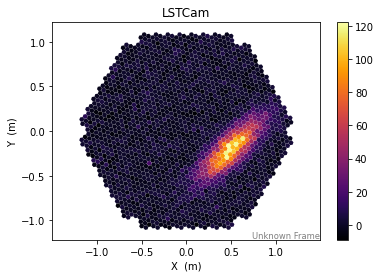

In [8]:
image, signal, background = model.generate_image(cam, intensity=10000, nsb_level_pe=10, rng=rng)

d = CameraDisplay(cam, image=image, cmap='inferno')
d.add_colorbar()

In [9]:
def sample_no_noise_no_cleaning():
    _, signal, _ = model.generate_image(cam, intensity=1000, nsb_level_pe=0, rng=rng)
    
    h = hillas_parameters(cam, signal)
    return h


def sample_no_noise_with_cleaning():
    _, signal, _ = model.generate_image(cam, intensity=1000, nsb_level_pe=0, rng=rng)
    
    mask = tailcuts_clean(cam, signal, 7, 5, min_number_picture_neighbors=2)
    
    h = hillas_parameters(cam[mask], signal[mask])
    return h


def sample_noise_with_cleaning():
    image, _, _ = model.generate_image(cam, intensity=1000, nsb_level_pe=5, rng=rng)
    
    mask = tailcuts_clean(cam, image, 7, 5, min_number_picture_neighbors=2)
    
    h = hillas_parameters(cam[mask], image[mask])
    return h

In [10]:
trials_no_noise_no_cleaning = [sample_no_noise_no_cleaning() for _ in tqdm(range(10000))]

  0%|          | 0/10000 [00:00<?, ?it/s]

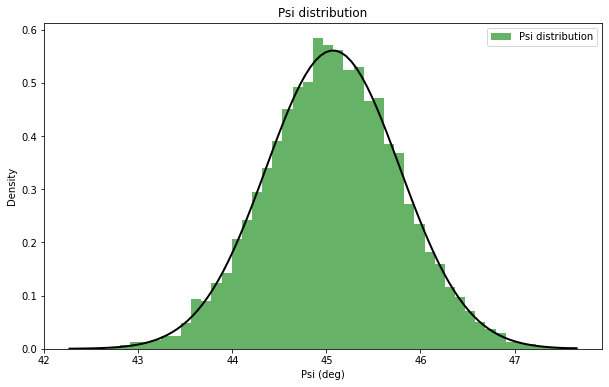

In [11]:

# Extraer los valores de `deltha` y graficar
psi = np.array([t.psi.to_value(u.deg) for t in trials_no_noise_no_cleaning if t is not None])

# Filtrar los valores NaN o infinitos
valid = np.isfinite(psi)
psi = psi[valid]

if psi.size == 0:
    print("No valid psi values to plot.")
else:
    plt.figure(figsize=(10, 6))
    plt.hist(psi, bins=50, density=True, alpha=0.6, color='g', label="Psi distribution")
    mu, std = norm.fit(psi)
    x = np.linspace(min(psi), max(psi), 100)
    plt.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2)
    plt.title("Psi distribution")
    plt.xlabel("Psi (deg)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


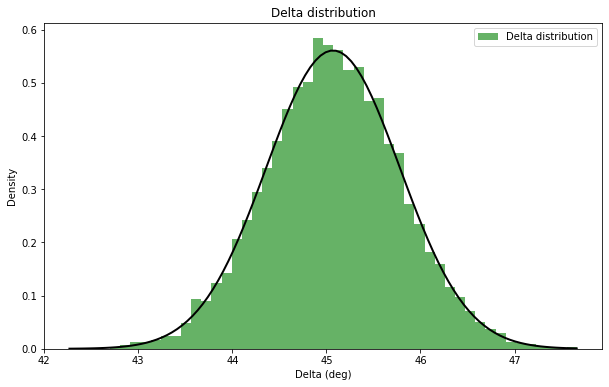

In [12]:

# Extraer los valores de `deltha` y graficar
deltha = np.array([t.deltha.to_value(u.deg) for t in trials_no_noise_no_cleaning if t is not None])

# Filtrar los valores NaN o infinitos
valid = np.isfinite(deltha)
deltha = deltha[valid]

if deltha.size == 0:
    print("No valid deltha values to plot.")
else:
    plt.figure(figsize=(10, 6))
    plt.hist(deltha, bins=50, density=True, alpha=0.6, color='g', label="Delta distribution")
    mu, std = norm.fit(deltha)
    x = np.linspace(min(deltha), max(deltha), 100)
    plt.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2)
    plt.title("Delta distribution")
    plt.xlabel("Delta (deg)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


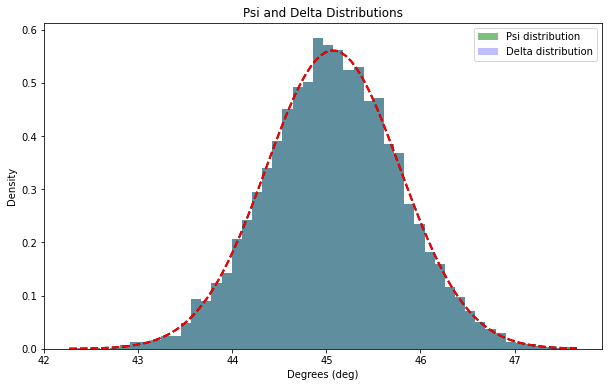

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Extraer los valores de `psi`
psi = np.array([t.psi.to_value(u.deg) for t in trials_no_noise_no_cleaning if t is not None])

# Filtrar los valores NaN o infinitos
valid_psi = np.isfinite(psi)
psi = psi[valid_psi]

# Extraer los valores de `deltha`
deltha = np.array([t.deltha.to_value(u.deg) for t in trials_no_noise_no_cleaning if t is not None])

# Filtrar los valores NaN o infinitos
valid_deltha = np.isfinite(deltha)
deltha = deltha[valid_deltha]

if psi.size == 0 and deltha.size == 0:
    print("No valid values to plot.")
else:
    plt.figure(figsize=(10, 6))

    # Graficar la distribución de psi
    if psi.size > 0:
        plt.hist(psi, bins=50, density=True, alpha=0.5, color='g', label="Psi distribution")
        mu_psi, std_psi = norm.fit(psi)
        x_psi = np.linspace(min(psi), max(psi), 100)
        plt.plot(x_psi, norm.pdf(x_psi, mu_psi, std_psi), 'k--', linewidth=2)

    # Graficar la distribución de deltha
    if deltha.size > 0:
        plt.hist(deltha, bins=50, density=True, alpha=0.25, color='b', label="Delta distribution")
        mu_deltha, std_deltha = norm.fit(deltha)
        x_deltha = np.linspace(min(deltha), max(deltha), 100)
        plt.plot(x_deltha, norm.pdf(x_deltha, mu_deltha, std_deltha), 'r--', linewidth=2)

    plt.title("Psi and Delta Distributions")
    plt.xlabel("Degrees (deg)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [14]:
# True model values
true_psi = 45 * u.deg  # Keep in degrees

# Lists to store errors and uncertainties
uncertainties_psi = []
errors_psi = []
uncertainties_deltha = []
errors_deltha = []

for trial in trials_no_noise_no_cleaning:
    if trial is not None:
        # Get uncertainties in degrees
        psi_uncertainty = trial.psi_uncertainty.to_value(u.deg)  # Convert to degrees
        deltha_uncertainty = trial.deltha_uncertainty.to_value(u.deg)  # Convert to degrees

        # Convert to degrees
        psi_estimated = trial.psi.to_value(u.deg)  # Convert to degrees
        deltha_estimated = trial.deltha.to_value(u.deg)  # Convert to degrees

        # Calculate absolute error for psi
        error_psi = np.abs(psi_estimated - true_psi.value)
        errors_psi.append(error_psi)
        uncertainties_psi.append(psi_uncertainty)

        # Calculate absolute error for delta
        error_deltha = np.abs(deltha_estimated - true_psi.value)
        errors_deltha.append(error_deltha)
        uncertainties_deltha.append(deltha_uncertainty)

# Convert to NumPy arrays for easier handling
uncertainties_psi = np.array(uncertainties_psi)
errors_psi = np.array(errors_psi)
uncertainties_deltha = np.array(uncertainties_deltha)
errors_deltha = np.array(errors_deltha)


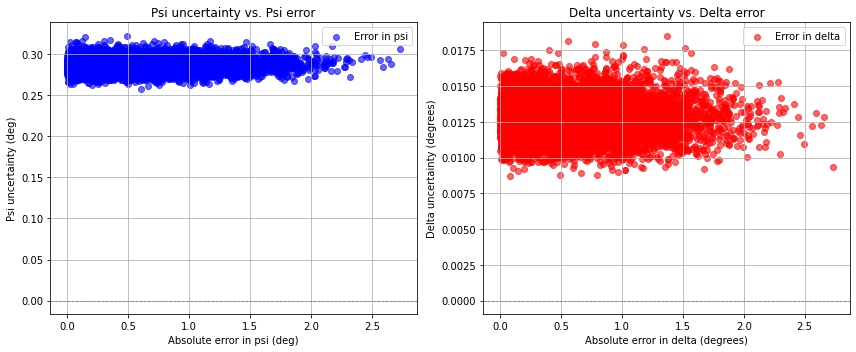

In [15]:


# Create the figure for psi
plt.figure(figsize=(12, 5))

# Plot for psi uncertainty vs. psi error
plt.subplot(1, 2, 1)  # Plot 1
plt.scatter(errors_psi, uncertainties_psi, alpha=0.6, color='b', label='Error in psi')
plt.ylabel('Psi uncertainty (deg)')
plt.xlabel('Absolute error in psi (deg)')
plt.title('Psi uncertainty vs. Psi error')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Horizontal line at Y=0
plt.grid()
plt.legend()

# Plot for delta uncertainty vs. delta error
plt.subplot(1, 2, 2)  # Plot 2
plt.scatter(errors_deltha, uncertainties_deltha, alpha=0.6, color='r', label='Error in delta')
plt.ylabel('Delta uncertainty (degrees)')
plt.xlabel('Absolute error in delta (degrees)')
plt.title('Delta uncertainty vs. Delta error')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Horizontal line at Y=0
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


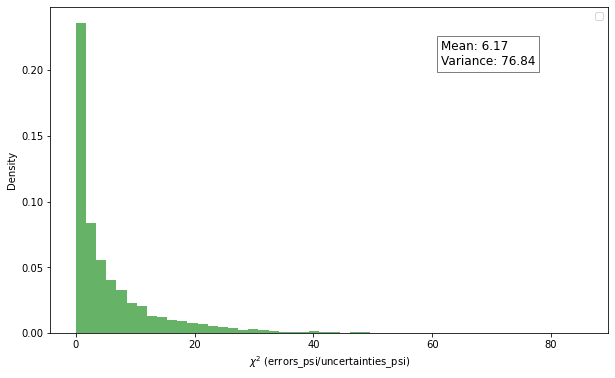

In [16]:
# Calculate chi-square
chi_square = (errors_psi / uncertainties_psi)**2

# Calculate mean and variance
mean_chi_square = np.mean(chi_square)
var_chi_square = np.var(chi_square)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(chi_square, bins=50, density=True, alpha=0.6, color='g')

# Title and labels
#plt.title("Psi distribution")
plt.xlabel(r"$\chi^2$ (errors_psi/uncertainties_psi)")  # Use LaTeX for the chi-squared symbol
plt.ylabel("Density")
plt.legend()

# Add mean and variance to the plot
plt.text(0.7, 0.9, f'Mean: {mean_chi_square:.2f}\nVariance: {var_chi_square:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Show plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


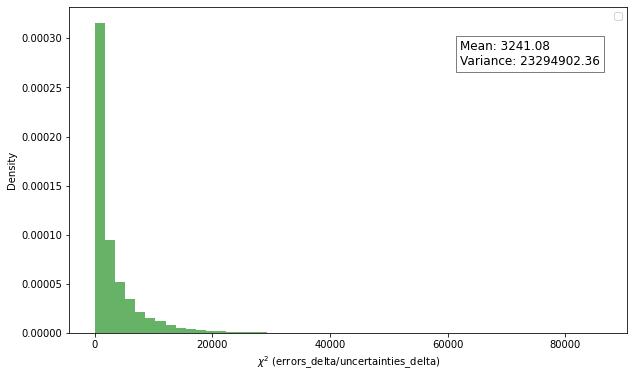

In [18]:
# Calculate chi-square
chi_square = (errors_deltha / uncertainties_deltha)**2

# Calculate mean and variance
mean_chi_square = np.mean(chi_square)
var_chi_square = np.var(chi_square)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(chi_square, bins=50, density=True, alpha=0.6, color='g')

# Title and labels
#plt.title("Psi distribution")
plt.xlabel(r"$\chi^2$ (errors_delta/uncertainties_delta)")  # Use LaTeX for the chi-squared symbol
plt.ylabel("Density")
plt.legend()

# Add mean and variance to the plot
plt.text(0.7, 0.9, f'Mean: {mean_chi_square:.2f}\nVariance: {var_chi_square:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Show plot
plt.show()

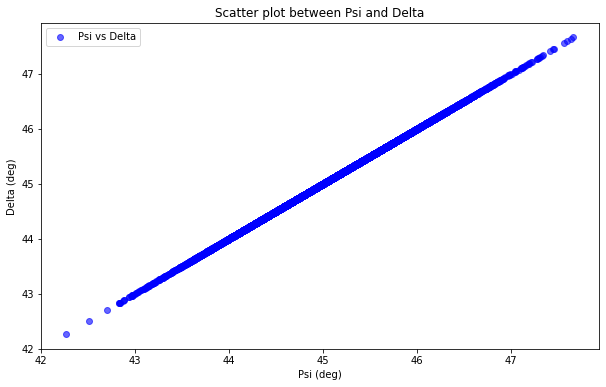

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Extraer los valores de `psi` y `deltha`
psi = np.array([t.psi.to_value(u.deg) for t in trials_no_noise_no_cleaning if t is not None])
deltha = np.array([t.deltha.to_value(u.deg) for t in trials_no_noise_no_cleaning if t is not None])

# Filtrar los valores NaN o infinitos para ambos
valid_psi = np.isfinite(psi)
valid_deltha = np.isfinite(deltha)
valid = valid_psi & valid_deltha

psi = psi[valid]
deltha = deltha[valid]
4
if psi.size == 0 or deltha.size == 0:
    print("No valid values to plot.")
else:
    plt.figure(figsize=(10, 6))
    plt.scatter(psi, deltha, alpha=0.6, color='b', label="Psi vs Delta")
    plt.title("Scatter plot between Psi and Delta")
    plt.xlabel("Psi (deg)")
    plt.ylabel("Delta (deg)")
    plt.legend()
    plt.show()


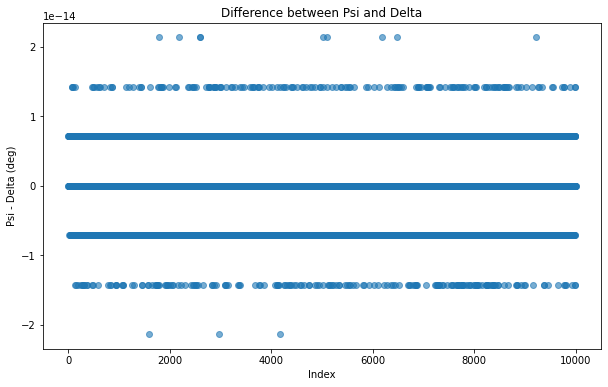

In [17]:
difference = psi - deltha
plt.figure(figsize=(10, 6))
plt.plot(difference, 'o', alpha=0.6)
plt.title("Difference between Psi and Delta")
plt.xlabel("Index")
plt.ylabel("Psi - Delta (deg)")
plt.show()


In [16]:
trials_no_noise_with_cleaning = [sample_no_noise_with_cleaning() for _ in tqdm(range(10000))]
trials_noise_cleaning = [sample_noise_with_cleaning() for _ in tqdm(range(10000))]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

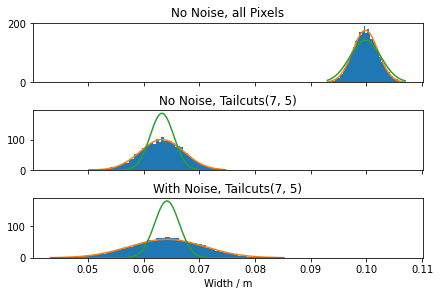

In [17]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, sharex=True)

titles = ['No Noise, all Pixels', 'No Noise, Tailcuts(7, 5)', 'With Noise, Tailcuts(7, 5)']
values = [trials_no_noise_no_cleaning, trials_no_noise_with_cleaning, trials_noise_cleaning]
for ax, trials, title in zip(axs, values, titles): 
    


    length = np.array([t.width.to_value(u.m) for t in trials])
    length_unc = np.array([t.width_uncertainty.to_value(u.m) for t in trials])
    
    limits = np.quantile(length, [0.001, 0.999])
    hist, edges, plot = ax.hist(length, bins=51, range=limits, density=True)
    
    x = np.linspace(edges[0], edges[-1], 500)

    ax.plot(x, norm.pdf(x, length.mean(), length.std()))
    ax.plot(x, norm.pdf(x, length.mean(), length_unc.mean()))
    ax.set_title(title)
axs[2].set_xlabel('Width / m')

fig.savefig("hillas_uncertainties.png", dpi=300)

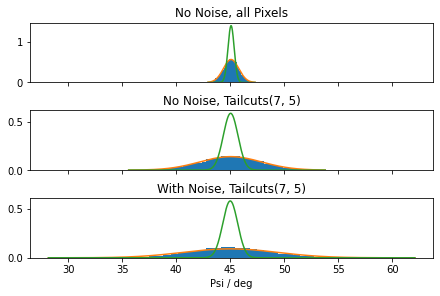

In [18]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, sharex=True)

titles = ['No Noise, all Pixels', 'No Noise, Tailcuts(7, 5)', 'With Noise, Tailcuts(7, 5)']
values = [trials_no_noise_no_cleaning, trials_no_noise_with_cleaning, trials_noise_cleaning]
for ax, trials, title in zip(axs, values, titles): 
    


    psi = np.array([t.psi.to_value(u.deg) for t in trials])
    psi_uncertainty = np.array([t.psi_uncertainty.to_value(u.deg) for t in trials])
    
    limits = np.quantile(psi, [0.001, 0.999])
    hist, edges, plot = ax.hist(psi, bins=51, range=limits, density=True)
    
    x = np.linspace(edges[0], edges[-1], 500)

    ax.plot(x, norm.pdf(x, psi.mean(), psi.std()))
    ax.plot(x, norm.pdf(x, psi.mean(), psi_uncertainty.mean()))
    ax.set_title(title)
axs[2].set_xlabel('Psi / deg')

fig.savefig("psi_hillas_uncertainties.png", dpi=500)

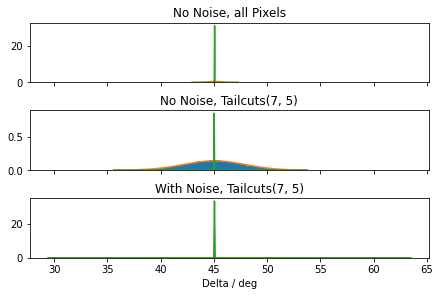

In [19]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, sharex=True)

titles = ['No Noise, all Pixels', 'No Noise, Tailcuts(7, 5)', 'With Noise, Tailcuts(7, 5)']
values = [trials_no_noise_no_cleaning, trials_no_noise_with_cleaning, trials_noise_cleaning]
for ax, trials, title in zip(axs, values, titles): 
    


    deltha = np.array([t.deltha.to_value(u.deg) for t in trials])
    deltha_uncertainty = np.array([t.deltha_uncertainty.to_value(u.deg) for t in trials])
    
    limits = np.quantile(deltha, [0.001, 0.999])
    hist, edges, plot = ax.hist(deltha, bins=51, range=limits, density=True)
    
    x = np.linspace(edges[0], edges[-1], 500)

    ax.plot(x, norm.pdf(x, deltha.mean(), deltha.std()))
    ax.plot(x, norm.pdf(x, deltha.mean(), deltha_uncertainty.mean()))
    ax.set_title(title)
axs[2].set_xlabel('Delta / deg')

fig.savefig("delta_hillas_uncertainties.png", dpi=300)